### Import Libraries

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
from scipy.stats import skew
import nbimporter
from collections import Counter
from Functions import calculate_descriptives, descriptive_stats

# Master Query from Database

In [2]:
# connect to DB and query data needed for modeling

In [3]:
# split data

# EDA on Clean Training Data

### Load in Dataframes

In [4]:
documents_table= pd.read_csv('documents_table.csv')
documents_table.head()
documents_table.dtypes

doc_id                              int64
doc_type                           object
year                                int64
drug                               object
drug administration error           int64
                                    ...  
eosinophil percentage decreased     int64
supraventricular tachycardia        int64
radiation skin injury               int64
hypokalaemia                        int64
all_reactions                      object
Length: 929, dtype: object

### Investigate most common drugs, referenced in historical documents

#### insights
* need to remove some values like air, body, oxygen

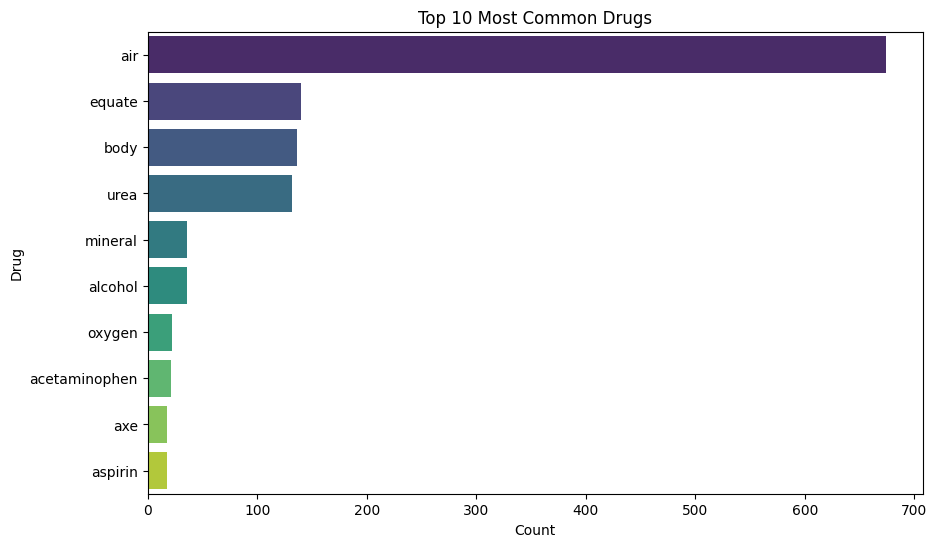

In [5]:
top_drugs = documents_table['drug'].value_counts().head(10)
top_drugs = top_drugs.reset_index().rename(columns={'index': 'drug', 'drug': 'count'})

# Plotting with Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='drug', data=top_drugs, palette='viridis')
plt.title('Top 10 Most Common Drugs')
plt.xlabel('Count')
plt.ylabel('Drug')
plt.show()

### Investigate most common reactions, referenced in historical documents

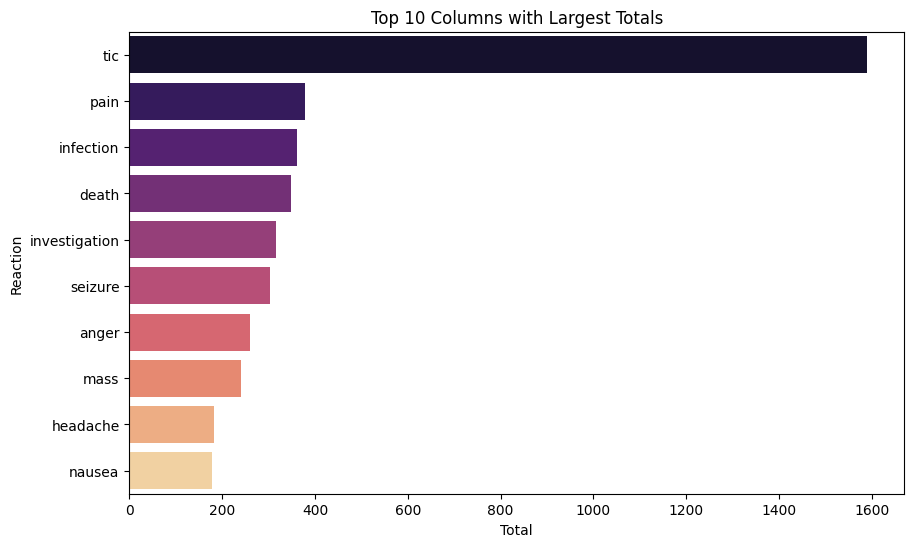

In [6]:
reaction_cols = documents_table.drop(columns=['doc_id','doc_type', 'year', 'drug', 'all_reactions']).sum()
top_reactions = reaction_cols.nlargest(10)


# Plotting with Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=top_reactions.values, y=top_reactions.index, palette='magma')
plt.title('Top 10 Columns with Largest Totals')
plt.xlabel('Total')
plt.ylabel('Reaction')
plt.show()

In [7]:
documents_table.head()

,doc_id,doc_type,year,drug,drug administration error,overdose,drug hypersensitivity,rhinorrhoea,unevaluable event,malaise,...,asphyxia,lymphocyte percentage decreased,blood pressure diastolic increased,aspiration,neutrophil percentage increased,eosinophil percentage decreased,supraventricular tachycardia,radiation skin injury,hypokalaemia,all_reactions
0,1,pr,2006,equate,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,['tic']
1,2,pr,2006,equate,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"['seizure', 'tic']"
2,3,talk,1991,axe,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,['investigation']
3,3,talk,1991,air,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,['investigation']
4,3,talk,1991,air,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,['investigation']


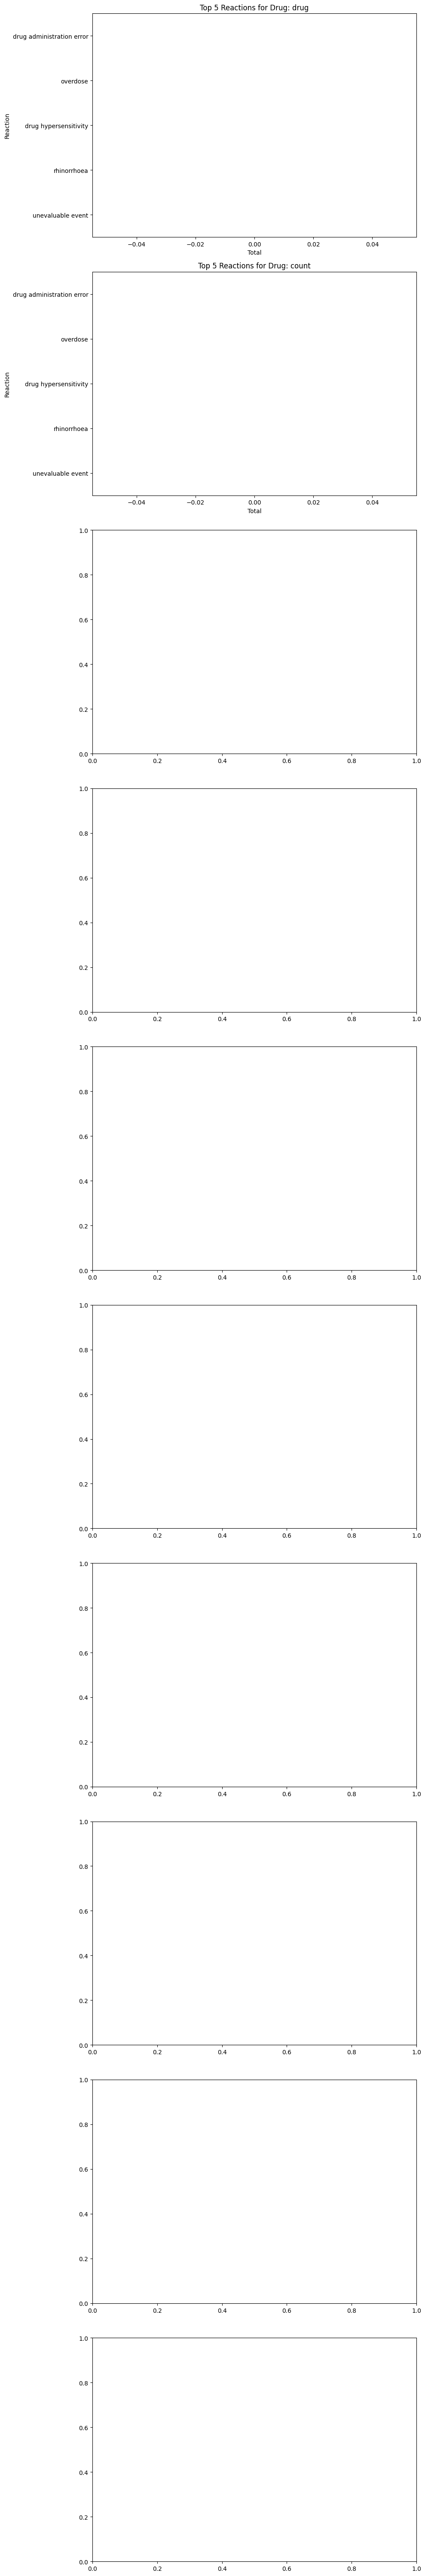

In [8]:

# Step 2: Filter documents_table to include only top 5 drugs
filtered_table = documents_table[documents_table['drug'].isin(top_drugs)]

# Step 3: Calculate top 5 reactions for each top drug
top_reactions_per_drug = {}
for drug in top_drugs:
    drug_data = filtered_table[filtered_table['drug'] == drug]
    reaction_counts = documents_table.drop(columns=['doc_id', 'doc_type', 'year', 'drug', 'all_reactions']).sum()
    top_reactions = reaction_counts.nlargest(5).index.tolist()
    top_reactions_per_drug[drug] = top_reactions

# Step 4: Create subplots for each drug
num_drugs = len(top_drugs)
fig, axes = plt.subplots(num_drugs, 1, figsize=(10, 6*num_drugs))

for i, drug in enumerate(top_drugs):
    ax = axes[i]
    drug_data = filtered_table[filtered_table['drug'] == drug]
    reaction_counts = drug_data.drop(columns=['doc_id', 'doc_type', 'year', 'drug','all_reactions']).sum()
    top_reactions = reaction_counts.nlargest(5)
    
    # Plotting
    sns.barplot(x=top_reactions.values, y=top_reactions.index, ax=ax, palette='magma')
    ax.set_title(f'Top 5 Reactions for Drug: {drug}')
    ax.set_xlabel('Total')
    ax.set_ylabel('Reaction')

plt.tight_layout()
plt.show()

# Reactions Table

### Outcome Variable

In [6]:
reactions = pd.read_csv('DataLibrary/reactions_table.csv')
reactions.head()

,patient_reaction_id,event_id,version_medDRA,outcome,reaction_processed
0,10,18,17.0,Recovered,['angioedema']
1,11,18,17.0,Recovered,"['laryngeal', 'oedema', 'laryngeal oedema']"
2,12,18,17.0,Recovered,"['face', 'oedema', 'face oedema']"
3,13,19,17.0,Fatal,"['tuberculosis', 'central', 'nervous', 'system..."
4,20,28,17.0,Recovered,"['respiratory', 'failure', 'respiratory failure']"


#### Graph
* Graph displays proportions post-cleaning and filtering for quality data. Original proportions can be found in DataProcessing within the patient_reactions_table module.

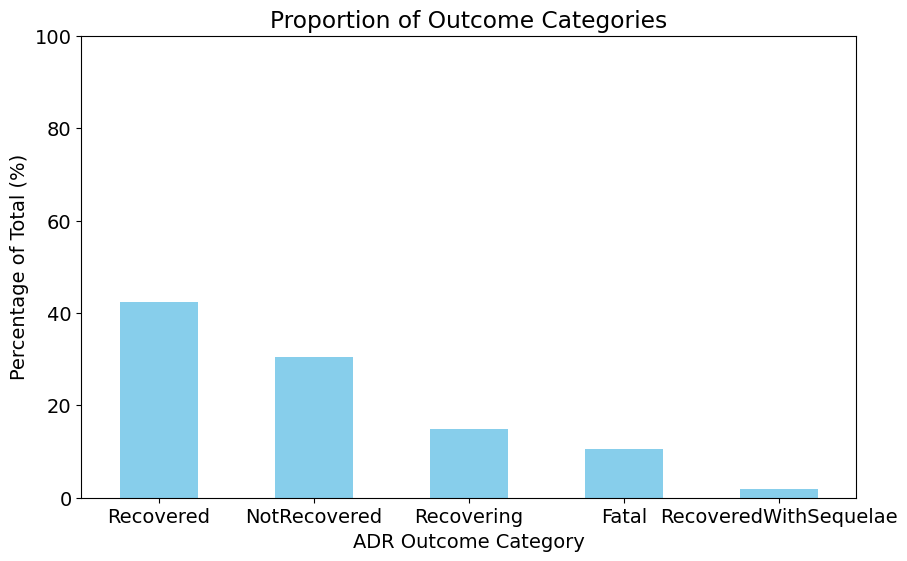

In [7]:
# Count the frequency of each category
category_counts = reactions['outcome'].value_counts()

# Calculate the percentages
total = len(reactions)
percentages = (category_counts / total) * 100

# Text size
plt.rcParams.update({'font.size': 14})

# Plotting the frequency bar plot
plt.figure(figsize=(10, 6))
bars = percentages.plot(kind='bar', color='skyblue')
plt.title('Proportion of Outcome Categories')
plt.xlabel('ADR Outcome Category')
plt.ylabel('Percentage of Total (%)')
plt.ylim(0, 100)
plt.xticks(rotation=0)

plt.show()

#### Descriptives

In [8]:
print(f"Frequency:", reactions['outcome'].value_counts()), print(f"Proportion:", reactions['outcome'].value_counts(normalize = True))

Frequency: outcome
Recovered                1984
NotRecovered             1425
Recovering                695
Fatal                     494
RecoveredWithSequelae      91
Name: count, dtype: int64
Proportion: outcome
Recovered                0.423118
NotRecovered             0.303903
Recovering               0.148219
Fatal                    0.105353
RecoveredWithSequelae    0.019407
Name: proportion, dtype: float64


(None, None)

### MeDRA Term Versions

#### Graph

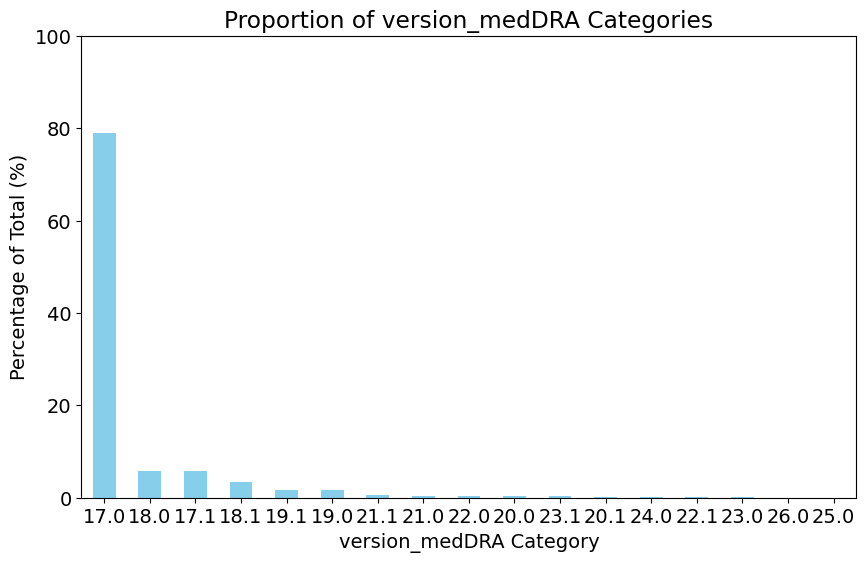

In [9]:
# Count the frequency of each category
category_counts = reactions['version_medDRA'].value_counts()

# Calculate the percentages
total = len(reactions)
percentages = (category_counts / total) * 100

# Text size
plt.rcParams.update({'font.size': 14})

# Plotting the frequency bar plot
plt.figure(figsize=(10, 6))
bars = percentages.plot(kind='bar', color='skyblue')
plt.title('Proportion of version_medDRA Categories')
plt.xlabel('version_medDRA Category')
plt.ylabel('Percentage of Total (%)')
plt.ylim(0, 100)
plt.xticks(rotation=0)

plt.show()

#### Descriptives

In [10]:
print(f"Frequency:", reactions['version_medDRA'].value_counts()), 
print(f"Proportion:", reactions['version_medDRA'].value_counts(normalize = True))

Frequency: version_medDRA
17.0    3702
18.0     276
17.1     274
18.1     157
19.1      82
19.0      75
21.1      23
21.0      21
22.0      21
20.0      19
23.1      17
20.1       8
24.0       4
22.1       4
23.0       3
26.0       2
25.0       1
Name: count, dtype: int64
Proportion: version_medDRA
17.0    0.789507
18.0    0.058861
17.1    0.058435
18.1    0.033483
19.1    0.017488
19.0    0.015995
21.1    0.004905
21.0    0.004479
22.0    0.004479
20.0    0.004052
23.1    0.003626
20.1    0.001706
24.0    0.000853
22.1    0.000853
23.0    0.000640
26.0    0.000427
25.0    0.000213
Name: proportion, dtype: float64


### Processed Reaction Terms
* There are tokens that would create a circular analysis. Death predicting an outcome of "fatal"? Need to clean.

In [16]:
# descriptive text stat function
descriptive_stats(reactions['reaction_processed'], top_n=5, verbose=True)

There are 4689 tokens in the data.
There are 1390 unique tokens in the data.
There are 176214 characters in the data.
The lexical diversity is 0.296 in the data.
The average token length is 37.580 in the data.
The variance of token lengths is 780.198 in the data.
The standard deviation of token lengths is 27.932 in the data.
The 5 most common tokens are [("['death']", 126), ("['dyspnoea']", 76), ("['diarrhoea']", 71), ("['pyrexia']", 62), ("['nausea']", 60)] in the data.


[4689,
 1390,
 0.2964384730219663,
 176214,
 37.580294305822136,
 780.1979140955125,
 27.932023093494543,
 [("['death']", 126),
  ("['dyspnoea']", 76),
  ("['diarrhoea']", 71),
  ("['pyrexia']", 62),
  ("['nausea']", 60)]]

# Events Table

In [31]:
events.dtypes

event_id                        int64
safetyreportid                 object
event_date                     object
serious                         int64
expedited                       int64
report_source                   int64
safetyreportversion           float64
country                        object
age                           float64
sex                             int64
company_name                  float64
event_graph            datetime64[ns]
dtype: object

In [17]:
# Update to query 
events = pd.read_csv('DataLibrary/events_table.csv')
events.head()

,event_id,year,expedited,report_source,country,age,sex,serious_outcome,company_name
0,1,2009,1,3,cn,26.0,1,Death,NaN
1,5,2014,2,1,us,NaN,2,NonSerious,"['pfizer', 'inc']"
2,6,2014,2,1,us,48.0,2,NonSerious,"['pfizer', 'inc']"
3,8,2015,2,1,us,65.0,2,NonSerious,['gilead']
4,9,2015,2,1,us,59.0,2,NonSerious,['gilead']


In [16]:
events.shape

(757, 11)

### Three-Level Outcome Based on Seriousness

#### Graph

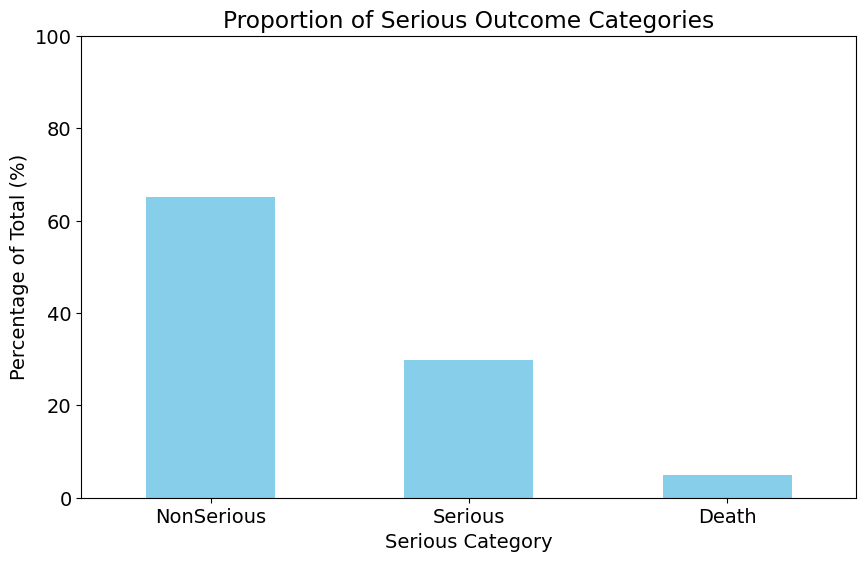

In [18]:
# Count the frequency of each category
category_counts = events['serious_outcome'].value_counts()

# Calculate the percentages
total = len(events)
percentages = (category_counts / total) * 100

# Text size
plt.rcParams.update({'font.size': 14})

# Plotting the frequency bar plot
plt.figure(figsize=(10, 6))
bars = percentages.plot(kind='bar', color='skyblue')
plt.title('Proportion of Serious Outcome Categories')
plt.xlabel('Serious Category')
plt.ylabel('Percentage of Total (%)')
plt.ylim(0, 100)
plt.xticks(rotation=0)

plt.show()

#### Descriptives

In [19]:
print(f"Frequency:", events['serious_outcome'].value_counts()), 
print(f"Proportion:", events['serious_outcome'].value_counts(normalize = True))

Frequency: serious_outcome
NonSerious    2805
Serious       1287
Death          213
Name: count, dtype: int64
Proportion: serious_outcome
NonSerious    0.651568
Serious       0.298955
Death         0.049477
Name: proportion, dtype: float64


### Age

#### Graph

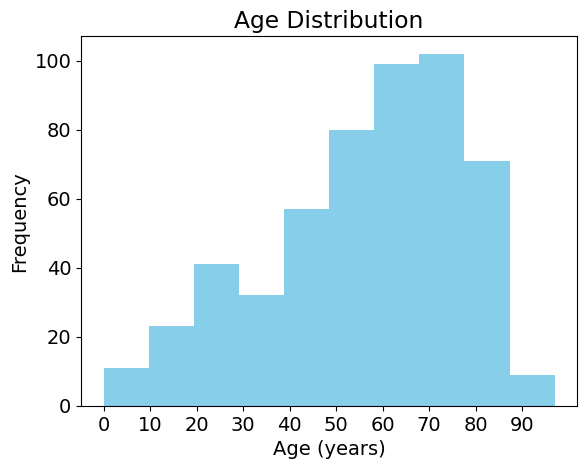

In [17]:
# Text size
plt.rcParams.update({'font.size': 14})

# Distribution of Age
plt.hist(events['age'].astype('float'), color = 'skyblue')
ticks = np.arange(0, 100, 10)  # Customize this range as needed
plt.xticks(ticks)
plt.xlabel('Age (years)')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.show()

#### Descriptives

In [18]:
events_age_descriptives = calculate_descriptives(events['age'])
print(events_age_descriptives)

+------------------------+----------+
| Statistic              |    Value |
+========================+==========+
| Median (Md)            |  60      |
+------------------------+----------+
| Mean (x-bar)           |  56.1878 |
+------------------------+----------+
| Standard Deviation (s) |  20.7576 |
+------------------------+----------+
| Variance (s2)          | 430.879  |
+------------------------+----------+
| Skewness               | nan      |
+------------------------+----------+
| First Quartile (Q1)    |  45      |
+------------------------+----------+
| Third Quartile (Q3)    |  71      |
+------------------------+----------+
None


### Report Dates

#### Descriptives

In [35]:
events['event_date'] = pd.to_datetime(events['event_date'])

events_year = pd.DataFrame()
events_year['year'] = events['event_date'].dt.year

event_year_descriptives = calculate_descriptives(events_year['year'])

+------------------------+-------------+
| Statistic              |       Value |
+========================+=============+
| Median (Md)            | 2014        |
+------------------------+-------------+
| Mean (x-bar)           | 2014.33     |
+------------------------+-------------+
| Standard Deviation (s) |    0.777021 |
+------------------------+-------------+
| Variance (s2)          |    0.603762 |
+------------------------+-------------+
| Skewness               |    3.74427  |
+------------------------+-------------+
| First Quartile (Q1)    | 2014        |
+------------------------+-------------+
| Third Quartile (Q3)    | 2015        |
+------------------------+-------------+


#### Graph

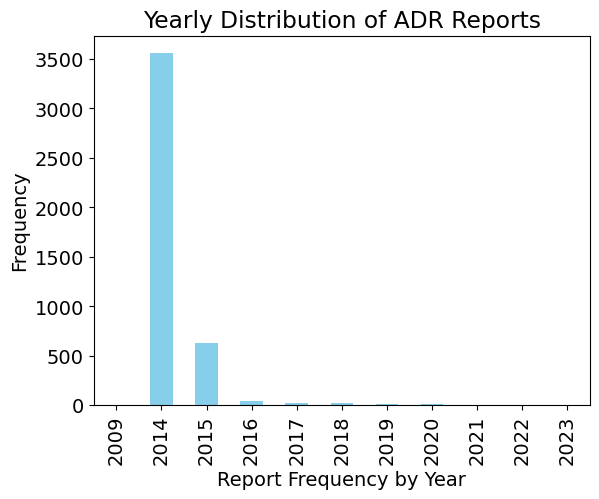

In [51]:
# Text size
plt.rcParams.update({'font.size': 14})

# Distribution of Reports
events['year'].value_counts().sort_index().plot(kind="bar", color="skyblue")

plt.xlabel('Report Frequency by Year')
plt.ylabel('Frequency')
plt.title('Yearly Distribution of ADR Reports')
plt.show()


### Expedited Criteria Status

#### Graph

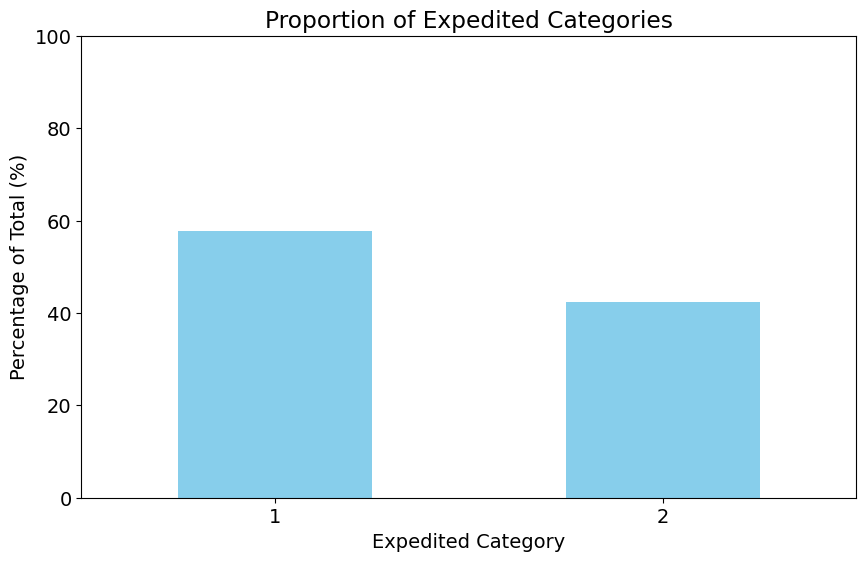

In [21]:
# Count the frequency of each category
category_counts = events['expedited'].value_counts()

# Calculate the percentages
total = len(events)
percentages = (category_counts / total) * 100

# Text size
plt.rcParams.update({'font.size': 14})

# Plotting the frequency bar plot
plt.figure(figsize=(10, 6))
bars = percentages.plot(kind='bar', color='skyblue')
plt.title('Proportion of Expedited Categories')
plt.xlabel('Expedited Category')
plt.ylabel('Percentage of Total (%)')
plt.ylim(0, 100)
plt.xticks(rotation=0)

plt.show()

#### Descriptives

In [ ]:
print(f"Frequency:", events['fulfillexpeditecriteria'].value_counts()), 
print(f"Proportion:", events['fulfillexpeditecriteria'].value_counts(normalize = True))

### Report Source

#### Graph

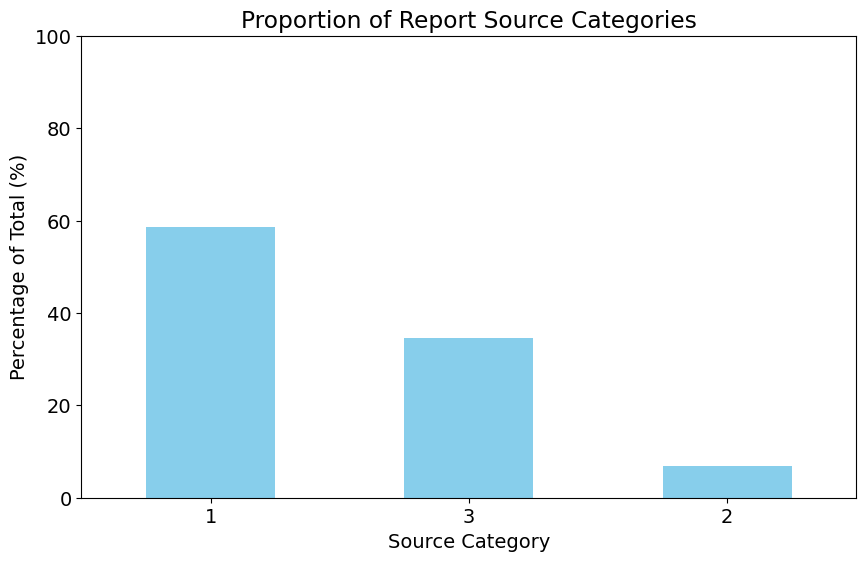

In [22]:
# Count the frequency of each category
category_counts = events['report_source'].value_counts()

# Calculate the percentages
total = len(events)
percentages = (category_counts / total) * 100

# Text size
plt.rcParams.update({'font.size': 14})

# Plotting the frequency bar plot
plt.figure(figsize=(10, 6))
bars = percentages.plot(kind='bar', color='skyblue')
plt.title('Proportion of Report Source Categories')
plt.xlabel('Source Category')
plt.ylabel('Percentage of Total (%)')
plt.ylim(0, 100)
plt.xticks(rotation=0)
#nums = [1,2,3]
#labels = ['Doc', 'Pharm', 'Other']
#plt.legend(nums, labels)
plt.show()

#### Descriptives

In [ ]:
print(f"Frequency:", events['report_source'].value_counts()), 
print(f"Proportion:", events['report_source'].value_counts(normalize = True))

### Company

#### Descriptives

In [23]:
print(f"Frequency:", events['company_name'].value_counts()), 
print(f"Proportion:", events['company_name'].value_counts(normalize = True))

Frequency: company_name
['incyte', 'corporation']                          853
['gilead']                                         469
['baxter']                                         367
['pubhosp']                                        243
['pfizer', 'inc']                                  218
                                                  ... 
['macleods', 'pharmaceuticals', 'ltd', 'mac']        1
['millennium', 'pharmaceuticals', 'inc', 'jnj']      1
['taro', 'pharmaceuticals', 'inc']                   1
['tpu']                                              1
['kowa']                                             1
Name: count, Length: 113, dtype: int64
Proportion: company_name
['incyte', 'corporation']                          0.211348
['gilead']                                         0.116204
['baxter']                                         0.090932
['pubhosp']                                        0.060208
['pfizer', 'inc']                                  0.054014
       

### Country 

#### Descriptives

In [25]:
print(f"Frequency:", events['country'].value_counts()), 
print(f"Proportion:", events['country'].value_counts(normalize = True))

Frequency: country
us    2776
jp     186
gb     185
fr     151
it     133
      ... 
mw       1
sz       1
si       1
lt       1
cl       1
Name: count, Length: 68, dtype: int64
Proportion: country
us    0.662530
jp    0.044391
gb    0.044153
fr    0.036038
it    0.031742
        ...   
mw    0.000239
sz    0.000239
si    0.000239
lt    0.000239
cl    0.000239
Name: proportion, Length: 68, dtype: float64


### Sex

#### Graph

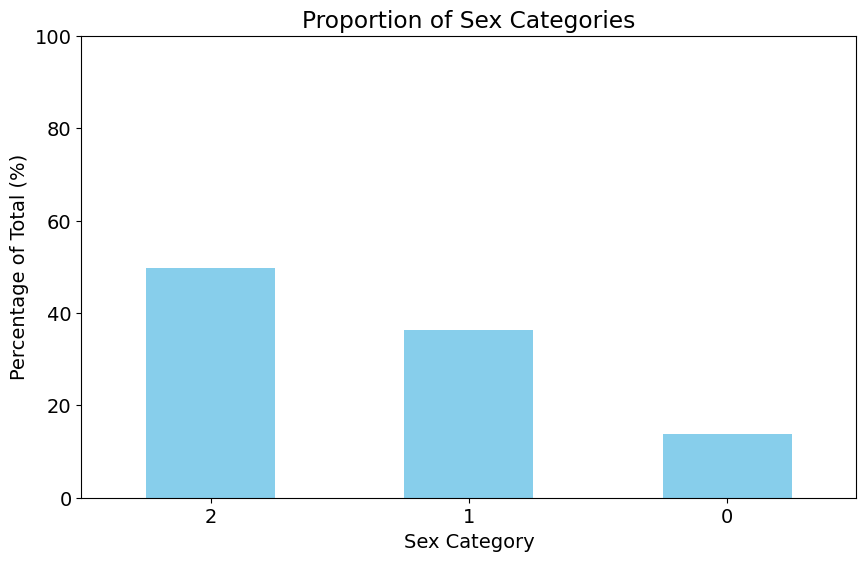

In [26]:
# Count the frequency of each category
category_counts = events['sex'].value_counts()

# Calculate the percentages
total = len(events)
percentages = (category_counts / total) * 100

# Text size
plt.rcParams.update({'font.size': 14})

# Plotting the frequency bar plot
plt.figure(figsize=(10, 6))
bars = percentages.plot(kind='bar', color='skyblue')
plt.title('Proportion of Sex Categories')
plt.xlabel('Sex Category')
plt.ylabel('Percentage of Total (%)')
plt.ylim(0, 100)
plt.xticks(rotation=0)
#nums = [1,2,3]
#labels = ['Doc', 'Pharm', 'Other']
#plt.legend(nums, labels)
plt.show()

#### Descriptives

In [27]:
print(f"Frequency:", events['sex'].value_counts()), 
print(f"Proportion:", events['sex'].value_counts(normalize = True))

Frequency: sex
2    2142
1    1567
0     596
Name: count, dtype: int64
Proportion: sex
2    0.497561
1    0.363995
0    0.138444
Name: proportion, dtype: float64


# Labels Table

In [28]:
# Update to query 
labels = pd.read_csv('DataLibrary/labels_table.csv')
labels.head()

,set_id,label_id,year,ndc,rxcui,unii,ingredients,warnings,drug_names,purpose
0,0000025c-6dbf-4af7-a741-5cbacaed519a,1,2021,['15631-0404'],NaN,['ETJ7Z6XBU4'],"['silicea', 'sucrose', 'silicon', 'dioxide', '...",NaN,"['silicea', 'dioxide', 'silicon', 'silicon dio...","['medical evidence', 'evidence fda', 'acne boi..."
1,0000076a-fc39-4208-ace8-6c2cb367904f,2,2015,NaN,NaN,NaN,"['chantecaille', 'protection', 'naturelle', 'b...",NaN,NaN,"['purpose sunscreen', 'purpose', 'sunscreen']"
2,00006ebc-ec2b-406c-96b7-a3cc422e933f,3,2023,NaN,NaN,NaN,"['mezereum', 'daphne', 'bark', 'sucrose', 'lac...",NaN,NaN,"['relieve', 'us relieve', 'us', 'itching', 're..."
3,00011703-bc55-4c0c-858c-149dc674bc3c,4,2023,NaN,NaN,NaN,"['ofloxacin', 'sodium', 'chloride', 'hydrochlo...","['immature animal', 'history', 'enhance', 'you...",NaN,NaN
4,000155a8-709c-44e5-a75f-cd890f3a7caf,5,2023,['50090-0481'],['198014'],['57Y76R9ATQ'],"['naproxen', 'croscarmellose', 'sodium', 'povi...",NaN,['naproxen'],NaN


### Number of Unique NDC, Rxcui, and UNII codes

In [32]:
print(f"Unique NDC:", len(set(labels['ndc']))),
print(f"Unique Rxcui:", len(set(labels['rxcui']))),
print(f"Unique Unii:", len(set(labels['unii'])))

Unique NDC: 4808
Unique Rxcui: 1878
Unique Unii: 1374


### Label Dates

#### Graph

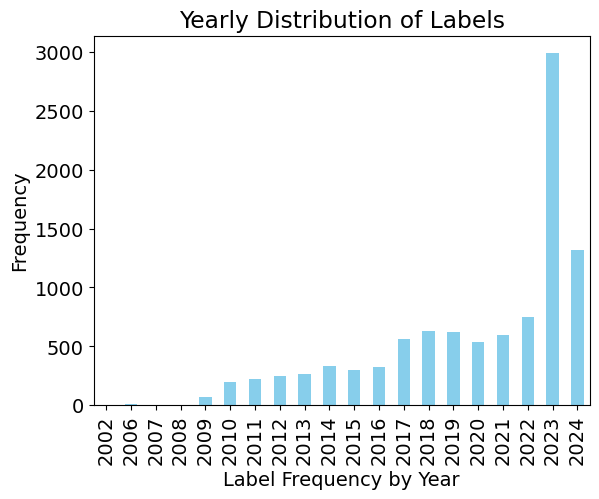

In [52]:
# Text size
plt.rcParams.update({'font.size': 14})

# Distribution of Reports
labels['year'].value_counts().sort_index().plot(kind="bar", color="skyblue")

plt.xlabel('Label Frequency by Year')
plt.ylabel('Frequency')
plt.title('Yearly Distribution of Labels')
plt.show()


#### Descriptives

In [30]:
labels_year_descriptives = calculate_descriptives(labels['year'])
labels_year_descriptives

+------------------------+-------------+
| Statistic              |       Value |
+========================+=============+
| Median (Md)            | 2022        |
+------------------------+-------------+
| Mean (x-bar)           | 2019.9      |
+------------------------+-------------+
| Standard Deviation (s) |    4.0462   |
+------------------------+-------------+
| Variance (s2)          |   16.3717   |
+------------------------+-------------+
| Skewness               |   -0.993913 |
+------------------------+-------------+
| First Quartile (Q1)    | 2017        |
+------------------------+-------------+
| Third Quartile (Q3)    | 2023        |
+------------------------+-------------+


### Ingredient List
* There are 9481 unique ingredients

In [34]:
# descriptive text stat function
descriptive_stats(labels['ingredients'], top_n=10, verbose=True)

There are 9986 tokens in the data.
There are 9481 unique tokens in the data.
There are 7827795 characters in the data.
The lexical diversity is 0.949 in the data.
The average token length is 783.877 in the data.
The variance of token lengths is 388913.665 in the data.
The standard deviation of token lengths is 623.629 in the data.
The 10 most common tokens are [("['oxygen']", 46), ("['buildable', 'blur', 'homosalate', 'octisalate', 'zinc', 'oxide', 'water', 'sodium', 'chloride', 'tetrahexyldecyl', 'ascorbate', 'dicaprylyl', 'carbonate', 'ethylhexyl', 'palmitate', 'aluminum', 'hydroxide', 'phenyl', 'trimethicone', 'flax', 'seed', 'triethoxycaprylylsilane', 'mica', 'quaternium', '90', 'bentonite', 'hydroxyacetophenone', 'dimethicone', 'tribehenin', 'butylene', 'glycol', 'cetyl', 'peg', 'ppg', '10', '1', 'hlb', '5', 'phytate', 'butyloctyl', 'salicylate', 'pentylene', 'caprylyl', 'trisiloxane', 'crosspolymer', '450000', 'mpa', '12', 'cyclopentasiloxane', 'propylene', 'titanium', 'dioxide',

[9986,
 9481,
 0.9494292008812337,
 7827795,
 783.8769276987783,
 388913.66450472083,
 623.6294288315144,
 [("['oxygen']", 46),
  ("['buildable', 'blur', 'homosalate', 'octisalate', 'zinc', 'oxide', 'water', 'sodium', 'chloride', 'tetrahexyldecyl', 'ascorbate', 'dicaprylyl', 'carbonate', 'ethylhexyl', 'palmitate', 'aluminum', 'hydroxide', 'phenyl', 'trimethicone', 'flax', 'seed', 'triethoxycaprylylsilane', 'mica', 'quaternium', '90', 'bentonite', 'hydroxyacetophenone', 'dimethicone', 'tribehenin', 'butylene', 'glycol', 'cetyl', 'peg', 'ppg', '10', '1', 'hlb', '5', 'phytate', 'butyloctyl', 'salicylate', 'pentylene', 'caprylyl', 'trisiloxane', 'crosspolymer', '450000', 'mpa', '12', 'cyclopentasiloxane', 'propylene', 'titanium', 'dioxide', 'ferric', 'red', 'ultramarine', 'blue', 'lauryl', '9', 'polydimethylsiloxyethyl', 'glycerin', 'methyl', 'methacrylate', 'dimethacrylate', 'yellow', 'ferrosoferric', 'buildable blur', 'blur homosalate', 'homosalate octisalate', 'octisalate zinc', 'zinc o

### Warnings
* There are over 1500 unique warnings tokens

In [37]:
# descriptive text stat function
descriptive_stats(labels['warnings'], top_n=1, verbose=True)

There are 1757 tokens in the data.
There are 1523 unique tokens in the data.
There are 32129330 characters in the data.
The lexical diversity is 0.867 in the data.
The average token length is 18286.471 in the data.
The variance of token lengths is 92976275.107 in the data.
The standard deviation of token lengths is 9642.421 in the data.
The 1 most common tokens are [("['blood pressure', 'concomitant initiated', 'tcas tramadol', 'atropine', 'phase myocardial', 'mutagenesis fertility', 'agitation', 'threatening contraindication', 'history', 'contraindication postmarketing', 'enhance', 'lack data', 'caution patient', 'antihypertensive guanethidine', 'reuptake inhibitor', 'higher', '15', 'snris', 'hepatocyte', 'concomitant', 'initiated clinically', 'general', 'similarly', 'increase precaution', 'hydrochloride', 'receiving', 'infarction arrhythmia', 'intraocular pressure', 'nervous', 'harm', 'frequency severity', 'symptom may', '10 adversely', 'effectiveness 15', 'cyclobenzaprine hydrochlor

[1757,
 1523,
 0.8668184405236198,
 32129330,
 18286.47125782584,
 92976275.10745504,
 9642.42060415615,
 [("['blood pressure', 'concomitant initiated', 'tcas tramadol', 'atropine', 'phase myocardial', 'mutagenesis fertility', 'agitation', 'threatening contraindication', 'history', 'contraindication postmarketing', 'enhance', 'lack data', 'caution patient', 'antihypertensive guanethidine', 'reuptake inhibitor', 'higher', '15', 'snris', 'hepatocyte', 'concomitant', 'initiated clinically', 'general', 'similarly', 'increase precaution', 'hydrochloride', 'receiving', 'infarction arrhythmia', 'intraocular pressure', 'nervous', 'harm', 'frequency severity', 'symptom may', '10 adversely', 'effectiveness 15', 'cyclobenzaprine hydrochloride', 'precaution', 'clonus muscle', 'hyperthermia neuromuscular', 'congestive', 'including', 'dos', 'controlled', 'impaired', 'data', '5 mg', 'abnormality', 'muscle', 'imipramine short', 'guanethidine similarly', 'exercised administered', 'approximately 40', 'a

### Drug Names

In [38]:
# descriptive text stat function
descriptive_stats(labels['drug_names'], top_n=5, verbose=True)

There are 4734 tokens in the data.
There are 3317 unique tokens in the data.
There are 780170 characters in the data.
The lexical diversity is 0.701 in the data.
The average token length is 164.801 in the data.
The variance of token lengths is 111548.357 in the data.
The standard deviation of token lengths is 333.989 in the data.
The 5 most common tokens are [("['ibuprofen']", 32), ("['buildable', 'octisalate', 'zinc oxide', 'oxide', 'buildable blur', 'homosalate', 'zinc', 'octisalate zinc', 'blur', 'homosalate octisalate']", 28), ("['oxygen']", 22), ("['prednisone']", 19), ("['gabapentin']", 18)] in the data.


[4734,
 3317,
 0.7006759611322348,
 780170,
 164.801436417406,
 111548.35727719315,
 333.9885586022269,
 [("['ibuprofen']", 32),
  ("['buildable', 'octisalate', 'zinc oxide', 'oxide', 'buildable blur', 'homosalate', 'zinc', 'octisalate zinc', 'blur', 'homosalate octisalate']",
   28),
  ("['oxygen']", 22),
  ("['prednisone']", 19),
  ("['gabapentin']", 18)]]

### Purpose

In [39]:
# descriptive text stat function
descriptive_stats(labels['purpose'], top_n=5, verbose=True)

There are 6042 tokens in the data.
There are 1840 unique tokens in the data.
There are 924681 characters in the data.
The lexical diversity is 0.305 in the data.
The average token length is 153.042 in the data.
The variance of token lengths is 78514.395 in the data.
The standard deviation of token lengths is 280.204 in the data.
The 5 most common tokens are [("['purpose sunscreen', 'purpose', 'sunscreen']", 630), ("['purpose', 'purpose antiseptic', 'antiseptic']", 427), ("['reliever', 'purpose', 'pain reliever', 'purpose pain', 'reliever fever', 'reducer', 'fever reducer', 'fever', 'pain']", 228), ("['purpose', 'purpose antihistamine', 'antihistamine']", 155), ("['purpose antiperspirant', 'purpose', 'antiperspirant']", 154)] in the data.


[6042,
 1840,
 0.30453492221118833,
 924681,
 153.04220456802383,
 78514.39461069765,
 280.2042016292719,
 [("['purpose sunscreen', 'purpose', 'sunscreen']", 630),
  ("['purpose', 'purpose antiseptic', 'antiseptic']", 427),
  ("['reliever', 'purpose', 'pain reliever', 'purpose pain', 'reliever fever', 'reducer', 'fever reducer', 'fever', 'pain']",
   228),
  ("['purpose', 'purpose antihistamine', 'antihistamine']", 155),
  ("['purpose antiperspirant', 'purpose', 'antiperspirant']", 154)]]

# Patient Drugs Table
* A subset of about 700 drugs are reported in FAERS

In [40]:
# Update to query 
drugs = pd.read_csv('DataLibrary/drugs_table.csv')
drugs.head()

,patient_drug_id,event_id,spl_set_id,indication,med_product,generic_name,manufacturers,manu_num,product_type,rxcui,rxcui_num,unii
0,1,1,NaN,"['drug', 'abuse', 'drug abuse']","['duragesic', '100', 'duragesic 100']",NaN,NaN,0,NaN,NaN,0,NaN
1,2,5,"['f9c63af9-d613-43fc-b8e5-ab6219f24c70', 'a569...",NaN,"['doxycycline', 'hyclate', 'doxycycline hyclate']","['doxycycline', 'hyclate', 'doxyclycline', 'do...","['mayne-pharma-commercial-', 'actavis-pharma',...",31,"['human', 'prescription', 'drug', 'human presc...","['1653433', '2122343', '1650143', '1652674', '...",31,"['19XTS3T51U', 'N12000U13O', '8ZL07I20SB']"
2,3,5,"['8ec4e4e5-a56e-4198-8428-6b770b9bf27d', 'ee71...",NaN,"['tramadol', 'hydrochloride', 'tramadol hydroc...","['tramadol', 'hydrochloride', 'tramadol hydroc...","['amneal-pharmaceuticals-ny-', 'zydus-pharmace...",18,"['human', 'prescription', 'drug', 'human presc...","['835603', '2395808', '833709', '833711', '833...",17,['9N7R477WCK']
3,4,5,['bfdfe235-d717-4855-a3c8-a13d26dadede'],NaN,['oxycontin'],"['oxycodone', 'hydrochloride', 'oxycodone hydr...",['purdue-pharma-lp'],1,"['human', 'prescription', 'drug', 'human presc...","['1049504', '1049545', '1049565', '1049576', '...",14,['C1ENJ2TE6C']
4,5,5,NaN,NaN,['talwin'],NaN,NaN,0,NaN,NaN,0,NaN


### Unique SPL Set IDs, Rxcui, and UNII codes

In [42]:
print(f"Unique SPL Set IDs:", len(set(drugs['spl_set_id']))),
print(f"Unique Rxcui:", len(set(drugs['rxcui']))),
print(f"Unique UNII:" ,len(set(drugs['unii'])))

Unique SPL Set IDs: 693
Unique Rxcui: 657
Unique UNII: 558


### Medicinal Product

In [44]:
# descriptive text stat function
descriptive_stats(drugs['med_product'], top_n=5, verbose=True)

There are 7779 tokens in the data.
There are 1527 unique tokens in the data.
There are 160956 characters in the data.
The lexical diversity is 0.196 in the data.
The average token length is 20.691 in the data.
The variance of token lengths is 544.952 in the data.
The standard deviation of token lengths is 23.344 in the data.
The 5 most common tokens are [("['jakafi']", 1166), ("['letairis']", 614), ("['forane', 'isoflurane', 'usp', 'forane isoflurane', 'isoflurane usp']", 170), ("['succinylcholine']", 141), ("['revlimid']", 137)] in the data.


[7779,
 1527,
 0.19629772464327033,
 160956,
 20.69109139992287,
 544.9518823285788,
 23.34420446981603,
 [("['jakafi']", 1166),
  ("['letairis']", 614),
  ("['forane', 'isoflurane', 'usp', 'forane isoflurane', 'isoflurane usp']",
   170),
  ("['succinylcholine']", 141),
  ("['revlimid']", 137)]]

### Generic Name

In [45]:
# descriptive text stat function
descriptive_stats(drugs['generic_name'], top_n=5, verbose=True)

There are 5849 tokens in the data.
There are 589 unique tokens in the data.
There are 168257 characters in the data.
The lexical diversity is 0.101 in the data.
The average token length is 28.767 in the data.
The variance of token lengths is 1315.749 in the data.
The standard deviation of token lengths is 36.273 in the data.
The 5 most common tokens are [("['ruxolitinib']", 1166), ("['ambrisentan']", 619), ("['lenalidomide']", 141), ("['succinylcholine']", 141), ("['rivaroxaban']", 115)] in the data.


[5849,
 589,
 0.10070097452555993,
 168257,
 28.766797743203966,
 1315.7493438402685,
 36.273259349557605,
 [("['ruxolitinib']", 1166),
  ("['ambrisentan']", 619),
  ("['lenalidomide']", 141),
  ("['succinylcholine']", 141),
  ("['rivaroxaban']", 115)]]

### Manufacturers

In [46]:
# descriptive text stat function
descriptive_stats(drugs['manufacturers'], top_n=5, verbose=True)

There are 5849 tokens in the data.
There are 457 unique tokens in the data.
There are 958050 characters in the data.
The lexical diversity is 0.078 in the data.
The average token length is 163.797 in the data.
The variance of token lengths is 478956.199 in the data.
The standard deviation of token lengths is 692.067 in the data.
The 5 most common tokens are [("['incyte-corporation']", 1166), ("['gilead-sciences']", 634), ("['genentech']", 207), ("['celgene-corporation']", 171), ("['dr-reddy-s-laboratories-']", 141)] in the data.


[5849,
 457,
 0.07813301419045991,
 958050,
 163.79723029577707,
 478956.198583541,
 692.0666142673991,
 [("['incyte-corporation']", 1166),
  ("['gilead-sciences']", 634),
  ("['genentech']", 207),
  ("['celgene-corporation']", 171),
  ("['dr-reddy-s-laboratories-']", 141)]]

In [28]:
num_manu_descriptives = calculate_descriptives(drugs['manu_num'])


+------------------------+------------+
| Statistic              |      Value |
+========================+============+
| Median (Md)            |    1       |
+------------------------+------------+
| Mean (x-bar)           |    7.53213 |
+------------------------+------------+
| Standard Deviation (s) |   40.2818  |
+------------------------+------------+
| Variance (s2)          | 1622.62    |
+------------------------+------------+
| Skewness               |   10.3081  |
+------------------------+------------+
| First Quartile (Q1)    |    0       |
+------------------------+------------+
| Third Quartile (Q3)    |    1       |
+------------------------+------------+


### Product Types
* Need to process into clean categories

In [47]:
# descriptive text stat function
descriptive_stats(drugs['product_type'], top_n=5, verbose=True)

There are 5849 tokens in the data.
There are 4 unique tokens in the data.
There are 444755 characters in the data.
The lexical diversity is 0.001 in the data.
The average token length is 76.039 in the data.
The variance of token lengths is 10.523 in the data.
The standard deviation of token lengths is 3.244 in the data.
The 5 most common tokens are [("['human', 'prescription', 'drug', 'human prescription', 'prescription drug']", 5654), ("['human', 'otc', 'drug', 'prescription', 'human otc', 'otc drug', 'drug prescription']", 110), ("['human', 'otc', 'drug', 'human otc', 'otc drug']", 54), ("['human', 'prescription', 'drug', 'otc', 'human prescription', 'prescription drug', 'drug otc']", 31)] in the data.


[5849,
 4,
 0.0006838775859121217,
 444755,
 76.03949393058643,
 10.522803368444956,
 3.2438870770180883,
 [("['human', 'prescription', 'drug', 'human prescription', 'prescription drug']",
   5654),
  ("['human', 'otc', 'drug', 'prescription', 'human otc', 'otc drug', 'drug prescription']",
   110),
  ("['human', 'otc', 'drug', 'human otc', 'otc drug']", 54),
  ("['human', 'prescription', 'drug', 'otc', 'human prescription', 'prescription drug', 'drug otc']",
   31)]]

# Prices Table

In [48]:
# Update to query 
prices = pd.read_csv('DataLibrary/prices_table.csv')
prices.head()

,ndc,unit_price,year,generic_brand
0,24385005452,0.28255,2022,1
1,70000047501,0.28255,2022,1
2,46122038576,0.78326,2022,1
3,70000036201,0.15365,2022,1
4,70000036202,0.15365,2022,1


### Number of Unique Drug Codes (NDC)

In [55]:
print(f"Unique NDC:", len(set(prices['ndc'])))

Unique NDC: 10000


### National Average Cost per Unit

#### Graph

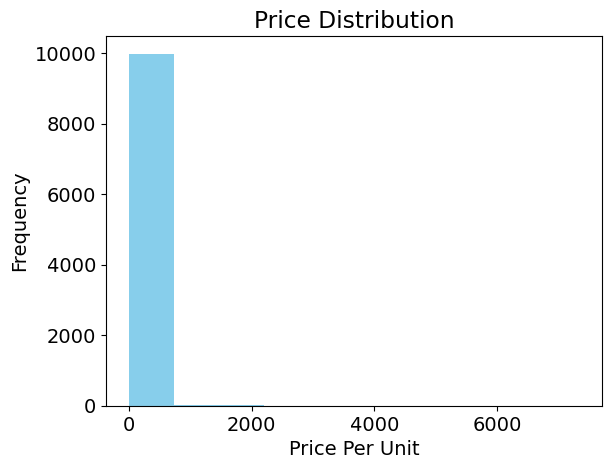

In [49]:
# Text size
plt.rcParams.update({'font.size': 14})

# Distribution of Age
plt.hist(prices['unit_price'].astype('float'), color = 'skyblue')
#ticks = np.arange(0, 100, 10)  # Customize this range as needed
#plt.xticks(ticks)
plt.xlabel('Price Per Unit')
plt.ylabel('Frequency')
plt.title('Price Distribution')
plt.show()

#### Descriptives

In [50]:
prices_descriptives = calculate_descriptives(prices['unit_price'])

+------------------------+--------------+
| Statistic              |        Value |
+========================+==============+
| Median (Md)            |     0.25819  |
+------------------------+--------------+
| Mean (x-bar)           |     9.31067  |
+------------------------+--------------+
| Standard Deviation (s) |   141.292    |
+------------------------+--------------+
| Variance (s2)          | 19963.5      |
+------------------------+--------------+
| Skewness               |    36.6264   |
+------------------------+--------------+
| First Quartile (Q1)    |     0.09805  |
+------------------------+--------------+
| Third Quartile (Q3)    |     0.783827 |
+------------------------+--------------+


### Effective Price Dates

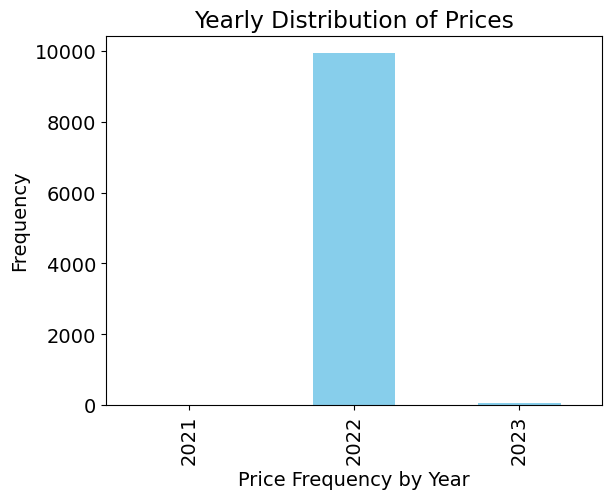

In [53]:
# Text size
plt.rcParams.update({'font.size': 14})

# Distribution of Reports
prices['year'].value_counts().sort_index().plot(kind="bar", color="skyblue")

plt.xlabel('Price Frequency by Year')
plt.ylabel('Frequency')
plt.title('Yearly Distribution of Prices')
plt.show()


### Drug Type

#### Graph

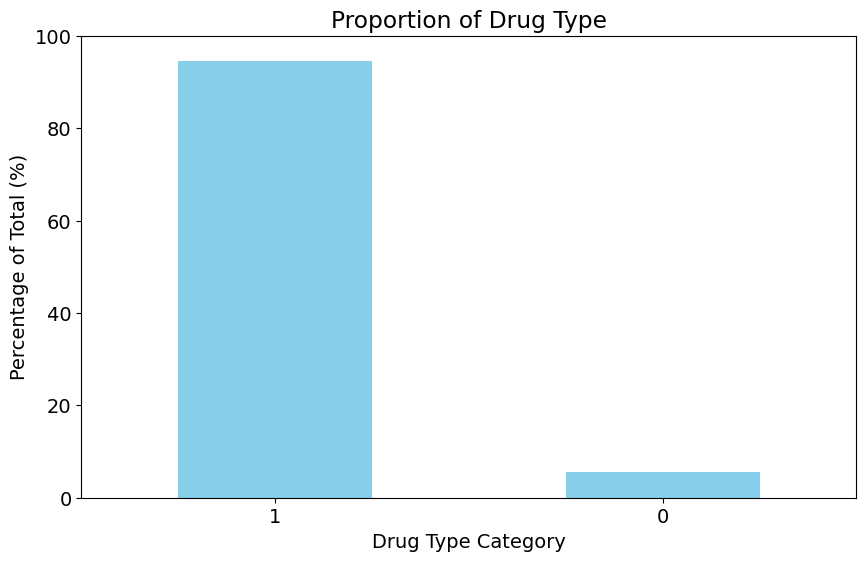

In [54]:
# Count the frequency of each category
category_counts = prices['generic_brand'].value_counts()

# Calculate the percentages
total = len(prices)
percentages = (category_counts / total) * 100

# Text size
plt.rcParams.update({'font.size': 14})

# Plotting the frequency bar plot
plt.figure(figsize=(10, 6))
bars = percentages.plot(kind='bar', color='skyblue')
plt.title('Proportion of Drug Type')
plt.xlabel('Drug Type Category')
plt.ylabel('Percentage of Total (%)')
plt.ylim(0, 100)
plt.xticks(rotation=0)
#nums = [1,0]
#labels = ['Generic', 'Brand']
#plt.legend(nums, labels)
plt.show()

#### Descriptives

In [ ]:
print(f"Frequency:", prices['generic_brand'].value_counts()), 
print(f"Proportion:", prices['generic_brand'].value_counts(normalize = True))

# Manufacturer Table

In [57]:
manus = pd.read_csv('DataLibrary/manus_table.csv')
manus.head()

,manu_id,spl_id,ndc,year,drug_names,drug_names.1,spl_set_id,unii,drug_names.2,drug_names.3,manufacturers
0,1,c1557e29-07ec-4532-b126-7df9afe531cd,11673-086,2014,Ethyl Alcohol Hand Sanitizer,"['alcohol hand', 'sanitizer', 'alcohol', 'hand...",['7dd1ec7c-f2ad-4801-a966-dd7ea0976b8a'],['3K9958V90M'],Ethyl Alcohol Hand Sanitizer,"['alcohol hand', 'sanitizer', 'alcohol', 'hand...",['target-']
1,2,cf587673-375f-46e8-82d2-db1f2c470e1f,11673-597,2016,"acetaminophen, dextromethorphan HBr, doxylamin...","['hcl severe', 'cold flu', 'dextromethorphan',...",['a2c0b14c-b6ab-4c41-a7c1-aaaaebc98a87'],NaN,"acetaminophen, dextromethorphan HBr, doxylamin...","['hcl severe', 'cold flu', 'dextromethorphan',...",['target-corporation']
2,3,0e071c42-0f7e-586e-e063-6394a90a9533,11673-991,2020,IBUPROFEN IBUPROFEN,['ibuprofen'],['8e86ae68-7687-79d6-e053-2995a90ac274'],['WK2XYI10QM'],IBUPROFEN IBUPROFEN,['ibuprofen'],['target-corporation']
3,4,aaab4ba6-0fc7-409b-b91c-b07041b6eb2b,11822-0620,2023,Loratadine childrens allergy relief,"['loratadine childrens', 'childrens allergy', ...",['539336e6-7979-47ed-b1ea-fd46ef547aee'],['7AJO3BO7QN'],Loratadine childrens allergy relief,"['loratadine childrens', 'childrens allergy', ...",['rite-aid-corporation']
4,5,0c540422-1578-9217-e063-6294a90ad06a,11822-3130,2023,HYDROCORTISONE Rite Aid Anti-itch,"['aid anti', 'aid', 'itch', 'rite', 'hydrocort...",['0c540422-1579-9217-e063-6294a90ad06a'],['WI4X0X7BPJ'],HYDROCORTISONE Rite Aid Anti-itch,"['aid anti', 'aid', 'itch', 'rite', 'hydrocort...",['rite-aid']


### Number of Unique SPL ID, NDC, SPL_SET_ID, UNII

In [58]:
print(f"Unique NDC:", len(set(manus['ndc']))),
print(f"Unique SPL ID:", len(set(manus['spl_id']))),
print(f"Unique SPL Set ID:", len(set(manus['spl_set_id']))),
print(f"Unique UNII:", len(set(manus['unii'])))

Unique NDC: 9899
Unique SPL ID: 8322
Unique SPL Set ID: 6902
Unique UNII: 1684


### Year

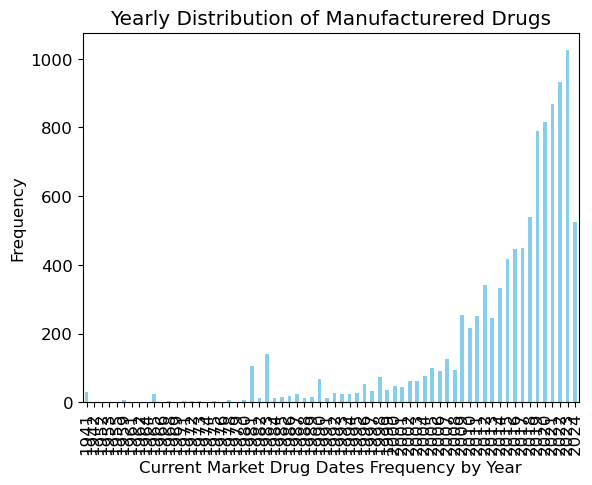

In [65]:
# Text size
plt.rcParams.update({'font.size': 12})

# Distribution of Reports
manus['year'].value_counts().sort_index().plot(kind="bar", color="skyblue")

plt.xlabel('Current Market Drug Dates Frequency by Year')
plt.ylabel('Frequency')
plt.title('Yearly Distribution of Manufacturered Drugs')
plt.show()


In [66]:
calculate_descriptives(manus['year'])

+------------------------+-----------+
| Statistic              |     Value |
+========================+===========+
| Median (Md)            | 2018      |
+------------------------+-----------+
| Mean (x-bar)           | 2014.74   |
+------------------------+-----------+
| Standard Deviation (s) |   10.8857 |
+------------------------+-----------+
| Variance (s2)          |  118.498  |
+------------------------+-----------+
| Skewness               |   -2.6561 |
+------------------------+-----------+
| First Quartile (Q1)    | 2012      |
+------------------------+-----------+
| Third Quartile (Q3)    | 2021      |
+------------------------+-----------+


### Drug Names

In [67]:
# descriptive text stat function
descriptive_stats(manus['drug_names_processed'], top_n=5, verbose=True)

There are 8528 tokens in the data.
There are 4474 unique tokens in the data.
There are 994238 characters in the data.
The lexical diversity is 0.525 in the data.
The average token length is 116.585 in the data.
The variance of token lengths is 22902.467 in the data.
The standard deviation of token lengths is 151.336 in the data.
The 5 most common tokens are [("['pregabalin']", 63), ("['ibuprofen']", 50), ("['levothyroxine sodium', 'levothyroxine', 'sodium']", 44), ("['gabapentin']", 43), ("['lamotrigine']", 37)] in the data.


[8528,
 4474,
 0.524624765478424,
 994238,
 116.58513133208255,
 22902.466955282944,
 151.33561033439204,
 [("['pregabalin']", 63),
  ("['ibuprofen']", 50),
  ("['levothyroxine sodium', 'levothyroxine', 'sodium']", 44),
  ("['gabapentin']", 43),
  ("['lamotrigine']", 37)]]

### Manufacturers/Distributors

In [68]:
# descriptive text stat function
descriptive_stats(manus['manufacturers'], top_n=5, verbose=True)

There are 8305 tokens in the data.
There are 968 unique tokens in the data.
There are 200408 characters in the data.
The lexical diversity is 0.117 in the data.
The average token length is 24.131 in the data.
The variance of token lengths is 75.467 in the data.
The standard deviation of token lengths is 8.687 in the data.
The 5 most common tokens are [("['hahnemann-laboratories']", 387), ("['bryant-ranch-prepack']", 304), ("['a-s-medication-solutions']", 172), ("['proficient-rx-']", 155), ("['boiron']", 141)] in the data.


[8305,
 968,
 0.11655629139072848,
 200408,
 24.131005418422635,
 75.46724456408865,
 8.687188530479158,
 [("['hahnemann-laboratories']", 387),
  ("['bryant-ranch-prepack']", 304),
  ("['a-s-medication-solutions']", 172),
  ("['proficient-rx-']", 155),
  ("['boiron']", 141)]]

# Combined Dataset from Master Query
## Analyzing Variable Interactions and Patterns

### All Numerical Variables

#### Correlation Martix

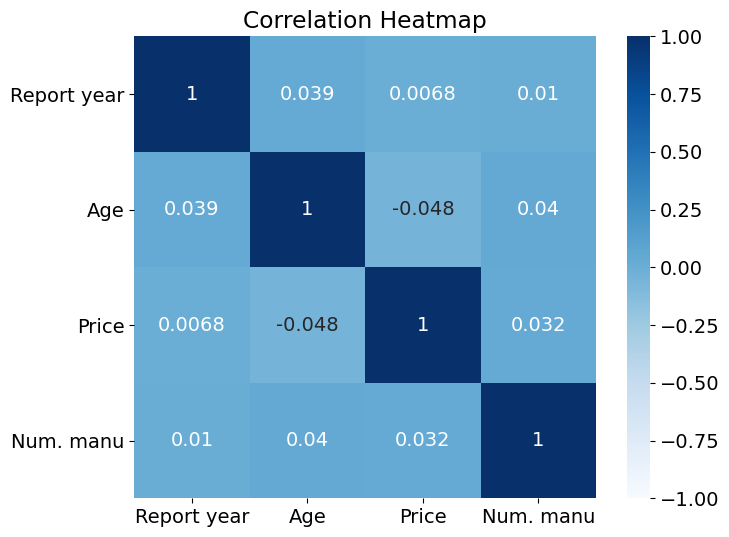

In [44]:
report_year = events_year['year']
age = events['age']
price = prices['unit_price']
num_manu = drugs['manu_num']


num_features = pd.DataFrame({
    'Report year': report_year,
    'Age': age,
    'Price': price,
    'Num. manu': num_manu
})
correlation_matrix = num_features.corr()

plt.figure(figsize=(8, 6)) 
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', vmin=-1, vmax=1, cbar=True, square=True)

plt.yticks(rotation=0)
plt.title('Correlation Heatmap')

plt.show()

In [38]:
num_features = pd.DataFrame({
    'report_year': report_year,
    'age': age,
    'price': price,
    'num_manu': num_manu
})

# Calculate the correlation matrix
correlation_matrix = num_features.corr()

In [ ]:
# matrix

#### Age x. Outcome

#### Prices x. Outcome

#### Number of Manufacturers x. Outcome

### All Text Variables

In [ ]:
# top token - naive bayes processing and/or tf-idf properties by outcome

### All Categorical Variables

#### Sex x. Outcome

#### Expedited Status x. Outcome

#### Report Source x. Outcome

#### Company Making Report x. Outcome

#### Country x. Outcome

#### Product Type x. Outcome

#### Manufacturer x. Outcome